In [60]:
#IMPORT_STATEMENTS
import time 
b = time.time()
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F 
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt 
import cv2 
import pickle
import random 
import numpy as np
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import numpy as np 
import os 
from pathlib import Path
a = time.time()
print('Imports complete in {} seconds.'.format(a-b))

enc_dims = [28*28, 500, 200, 100]
bottle_neck_dims = 15
dec_dims = [200, 500, 28*28]

class Encoder_Decoder(nn.Module):
    def __init__(self):
        super(Encoder_Decoder, self).__init__()
        self.lin_enc_1 = nn.Linear(enc_dims[0], enc_dims[1])
        self.lin_enc_2 = nn.Linear(enc_dims[1], enc_dims[2])
        self.lin_enc_3 = nn.Linear(enc_dims[2], enc_dims[3])
        self.lin_enc_bottle_neck = nn.Linear(enc_dims[3], bottle_neck_dims)
        self.lin_dec_bottle_neck = nn.Linear(bottle_neck_dims, dec_dims[0])
        self.lin_dec_1 = nn.Linear(dec_dims[0], dec_dims[1])
        self.lin_dec_2 = nn.Linear(dec_dims[1], dec_dims[2])
        print('Encoder-Decoder net created')
        self.init_weights()

    def forward(self, x):
        x = self.enc_pass(x)
        x = self.dec_pass(x)
        return x

    def enc_pass(self, x):
        x = x.view(-1, enc_dims[0])
        x = F.relu(self.lin_enc_1(x))
        x = F.relu(self.lin_enc_2(x))
        x = F.relu(self.lin_enc_3(x))
        x = F.elu(self.lin_enc_bottle_neck(x))
        return x

    def dec_pass(self, x):
        x = x.view(-1, bottle_neck_dims)
        x = F.relu(self.lin_dec_bottle_neck(x))
        x = F.relu(self.lin_dec_1(x))
        x = F.relu(self.lin_dec_2(x))
        return x

    def init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_uniform_(module.weight)
        print('Weights initialized as per kaiming uniform criterion')


def plot_loss(epochs, train_loss, val_loss):
    plt.style.use('fivethirtyeight')
    plt.plot(epochs, train_loss, linewidth = 0.8, color = 'r', label = 'train_loss')
    plt.plot(epochs, val_loss, linewidth = 0.8, color = 'b', label = 'val_loss')
    plt.axhline(y = min(val_loss), linewidth = 0.8, color = 'g' ,label = 'min_loss')
    plt.axvline(x = epochs[val_loss.index(min(val_loss))], linewidth = 0.8, color = 'g')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation loss')
    plt.show()

def plot_acc(epochs, train_acc, val_acc, val_loss):
    plt.style.use('fivethirtyeight')
    plt.plot(epochs, train_acc, linewidth = 0.8, color = 'r', label = 'train_acc')
    plt.plot(epochs, val_acc, linewidth = 0.8, color = 'b', label = 'val_acc')
    plt.axhline(y = max(val_acc), linewidth = 0.8, color = 'm' ,label = 'max_acc')
    plt.axvline(x = epochs[val_loss.index(min(val_loss))], linewidth = 0.8, color = 'g', label = 'min_loss')
    plt.axvline(x = epochs[val_acc.index(max(val_acc))], linewidth = 0.8, color = 'm')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Acc')
    plt.show()

def loss_minima(loss_list): #Inputs: loss array
    _loss = sorted(loss_list)
    return _loss[0]

def one_hot(k, N_OUTPUTS):
    a = []
    for i in range(N_OUTPUTS):
        if i != k:
            a.append(0)
        else:
            a.append(1)
    return torch.tensor(a)

def get_accuracy(prediction, target):
    pred = prediction.tolist()[0]
    tar = target.tolist()[0]
    sum_ = []
    for i in range(len(pred)):
        if tar[i] != 0:
            sum_.append(1-(abs(pred[i] - tar[i])/tar[i]))
        else:
            #sum_.append(1-(abs(pred[i]-tar[i])/0.0001))
            pass
    return np.average(sum_)
    
#---------------------------------------------------------

# The much more simpler train_optimizer
# Avoids overfitting and saves the best model
def train_optimizer(val_loss_list, decreasing = True, save_on_device = torch.device('cpu')):
    import os 
    from pathlib import Path
    if decreasing is True and val_loss_list[-1] == min(val_loss_list):
        if SAVE_MODEL is True:
            if Path(f'./{checkpoint_filename}').is_file():
                os.remove(f'./{checkpoint_filename}')
                net.to(save_on_device)
                torch.save(net.state_dict(), checkpoint_filename)
                net.to(device)
                if verbose is True:
                    print(f'New model saved as <{checkpoint_filename}> Previous model removed.')
                else:
                    pass
            else:
                net.to(save_on_device)
                torch.save(net.state_dict(), checkpoint_filename)
                net.to(device)
                if verbose is True:
                    print(f'New model saved as <{checkpoint_filename}>')
                else:
                    pass
        else:
            pass
        return True
    elif decreasing is not True and val_loss_list[-1] == max(val_loss_list):
        if SAVE_MODEL is True:
            if Path(f'./{checkpoint_filename}').is_file():
                os.remove(f'./{checkpoint_filename}')
                net.to(save_on_device)
                torch.save(net.state_dict(), checkpoint_filename)
                net.to(device)
                if verbose is True:
                    print(f'New model saved as <{checkpoint_filename}> Previous model removed.')
                else:
                    pass
            else:
                net.to(save_on_device)
                torch.save(net.state_dict(), checkpoint_filename)
                net.to(device)
                if verbose is True:
                    print(f'New model saved as <{checkpoint_filename}>')
                else:
                    pass
        else:
            pass
        return True
    elif decreasing is True and val_loss_list[-1] != min(val_loss_list):
        return False
    elif decreasing is not True and val_loss_list[-1] != max(val_loss_list):
        return False

Imports complete in 0.0002613067626953125 seconds.


In [61]:
net = Encoder_Decoder()
BATCH_SIZE = 30
train = torchvision.datasets.MNIST('', download = True, train = True, transform = transforms.Compose([transforms.ToTensor()])) 
test = torchvision.datasets.MNIST('', download = True, train = False, transform = transforms.Compose([transforms.ToTensor()]))
print('Data download complete.')
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = True)
print('Data processing complete.')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')

Encoder-Decoder net created
Weights initialized as per kaiming uniform criterion
Data download complete.
Data processing complete.


Running on cuda:0.

**Each epoch takes 0.28 Minutes to train.
**Each epoch takes 0.25 Minutes to test.
Validation loss of epoch 1 = 0.021999314979906193.
Validation acc score of epoch 1 = 0.05547715547237083.

Validation loss of epoch 2 = 0.019870991823321672.
Validation acc score of epoch 2 = 0.11960272547353289.

Validation loss of epoch 3 = 0.019453690517030192.
Validation acc score of epoch 3 = 0.10541807280427207.

Validation loss of epoch 4 = 0.018095394814456812.
Validation acc score of epoch 4 = 0.15231581606942762.

Validation loss of epoch 5 = 0.018132784747157713.
Validation acc score of epoch 5 = 0.16724190744330797.

Validation loss of epoch 6 = 0.017438703494746004.
Validation acc score of epoch 6 = 0.2071837010025471.

Validation loss of epoch 7 = 0.017558680597029162.
Validation acc score of epoch 7 = 0.177805436696828.

Validation loss of epoch 8 = 0.017415261666616427.
Validation acc score of epoch 8 = 0.10900652123850343.



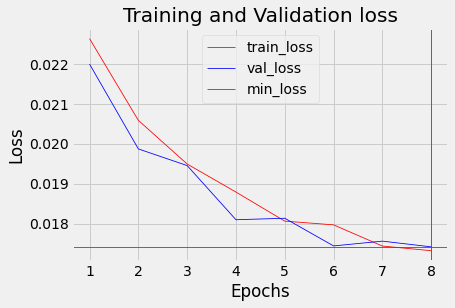

Validation loss of epoch 9 = 0.017183074360783212.
Validation acc score of epoch 9 = 0.15099437691711118.

Validation loss of epoch 10 = 0.017055728904320857.
Validation acc score of epoch 10 = 0.13364808984273757.

Validation loss of epoch 11 = 0.016649301374633798.
Validation acc score of epoch 11 = 0.1487391984512921.

Validation loss of epoch 12 = 0.016520988278766163.
Validation acc score of epoch 12 = 0.19038685840061498.

Validation loss of epoch 13 = 0.016454197902430315.
Validation acc score of epoch 13 = 0.2307033701858251.

Validation loss of epoch 14 = 0.016794778568891344.
Validation acc score of epoch 14 = 0.1537197004845577.

Validation loss of epoch 15 = 0.01603906415658421.
Validation acc score of epoch 15 = 0.25054867062973313.

Validation loss of epoch 16 = 0.01646085551326396.
Validation acc score of epoch 16 = 0.13317974629409154.



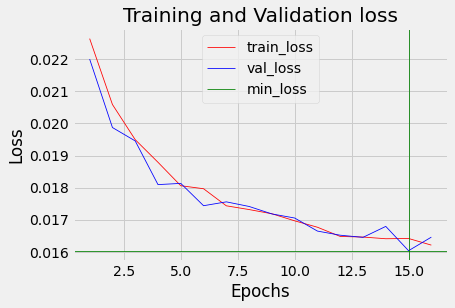

Validation loss of epoch 17 = 0.016221409210463753.
Validation acc score of epoch 17 = 0.1634048056851836.

Validation loss of epoch 18 = 0.016160375177435345.
Validation acc score of epoch 18 = 0.20660010434013792.

Training Terminated.
Model trained and saved. Reference epoch = 15.
Total time for training = 0 Hrs. 9 Min. 29.67 Seconds.


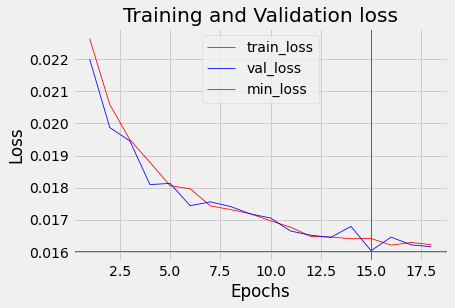

In [62]:
optimizer = optim.Adam(net.parameters(), lr = 0.003)
loss_fn = nn.MSELoss()
train_data = train_loader
test_data = test_loader
net = net.to(device)
N_EPOCH_THRESHOLD = 3
SAVE_MODEL = True
checkpoint_filename = 'auto_encoder_mnist.pt'
PLT_SHOW = 8
verbose = False
temp_thresh_count = N_EPOCH_THRESHOLD

print(f'Running on {device}.\n')
train_flag = True
save_model_ref = 0
epoch_count = 1
epoch_list = []
val_loss_list = []
train_loss_list = []
train_acc_list = []
val_acc_list = []
acc_list = []
b = time.time()
while train_flag:
    if verbose:
        disable_tqdm = False
    else:
        disable_tqdm = True 
    temp_arr = []
    temp_arr1 = []
    correct = 0
    total = 0
    train_correct = 0
    train_total = 0
    if verbose:
        print(f'\n----------Training epoch {epoch_count}----------')
    else:
        pass
    train_bef = time.time()
    # Training loop-start
    for data in tqdm(train_data, disable = disable_tqdm):
        X, y = data
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        out = net(X.float())
        train_loss = loss_fn(out.float(), X.view(-1,enc_dims[0]).float())
        train_loss = train_loss.float()
        train_loss.backward()
        optimizer.step()
        temp_arr1.append(train_loss.item())
    train_aft = time.time()
    temp_arr1 = torch.tensor(temp_arr1)
    l_train_data = len(train_data)
    train_loss_list.append(torch.mean(temp_arr1[-int(l_train_data*0.25):]))
    # Training loop-end
    if verbose:
        print(f'Training loss of epoch {epoch_count} = {torch.mean(temp_arr1[-int(l_train_data*0.25):]).item()}.')
        print(f'----------Testing epoch {epoch_count}----------')
    elif verbose is not True and epoch_count < 2:
        print(f'**Each epoch takes {round(float(train_aft - train_bef)/60.0, 2)} Minutes to train.')
    # Validation loop-start
    with torch.no_grad():
        temp_acc_array = []
        test_bef = time.time()
        for data in tqdm(test_data, disable = disable_tqdm):
            X, y = data
            X = X.to(device)
            y = y.to(device)
            out = net(X.float())
            val_acc = get_accuracy(out, X.view(-1,enc_dims[0]).float())
            temp_acc_array.append(val_acc)
            val_loss = loss_fn(out.float(), X.view(-1,enc_dims[0]).float())
            temp_arr.append(val_loss.to(cpu).item())
    test_aft = time.time()
    val_acc_list.append(np.average(temp_acc_array))
    val_loss_list.append(np.average(temp_arr))
    epoch_list.append(epoch_count)
    # Validation loop-end
    if verbose is not True and epoch_count < 2:
        print(f'**Each epoch takes {round(float(test_aft - test_bef)/60.0, 2)} Minutes to test.')
    else:
        pass
    print(f'Validation loss of epoch {epoch_count} = {np.average(temp_arr)}.')
    print(f'Validation acc score of epoch {epoch_count} = {np.average(temp_acc_array)}.\n')
    if epoch_count%PLT_SHOW == 0:
        plot_loss(epoch_list, train_loss_list, val_loss_list)
    epoch_count += 1
    # train_optimizer()-start
    temp_flag = train_optimizer(val_loss_list)
    if temp_flag is False:
        temp_thresh_count -= 1
        if verbose is True:
            print('***Threshold Detected***')
    elif temp_flag is True:
        temp_thresh_count = N_EPOCH_THRESHOLD
    if temp_thresh_count == 0:
        train_flag = False
    else:
        pass
    # train_optimizer()-end
a = time.time()
print('Training Terminated.')
if SAVE_MODEL is True:
    print(f'Model trained and saved. Reference epoch = {val_loss_list.index(min(val_loss_list))+1}.')
else:
    print(f'Model trained. Reference for loss minima-epoch = {val_loss_list.index(min(val_loss_list))+1}')
print(f'Total time for training = {int((a-b)/3600)} Hrs. {int((a-b)/60)} Min. {round((a-b)%60, 2)} Seconds.')
plot_loss(epoch_list, train_loss_list, val_loss_list)

Encoder-Decoder net created
Weights initialized as per kaiming uniform criterion


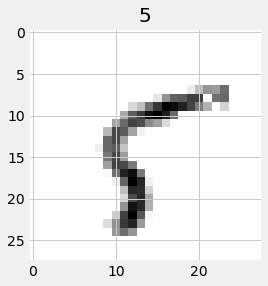

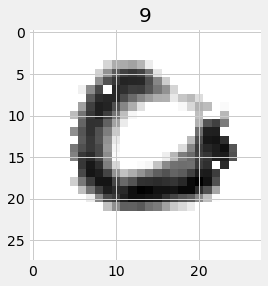

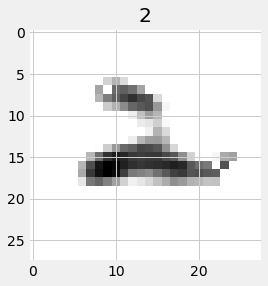

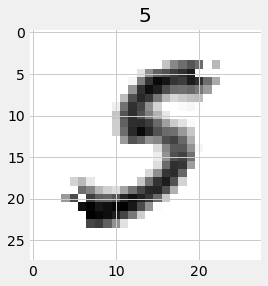

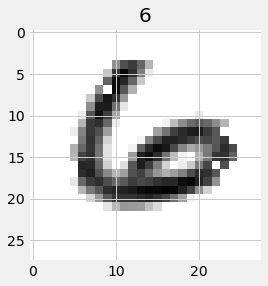

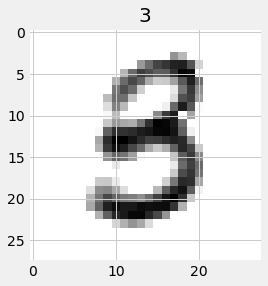

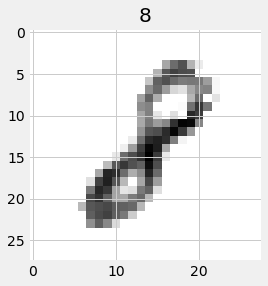

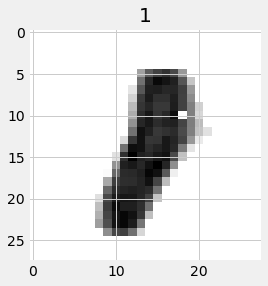

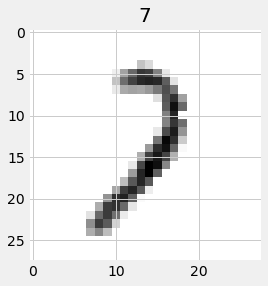

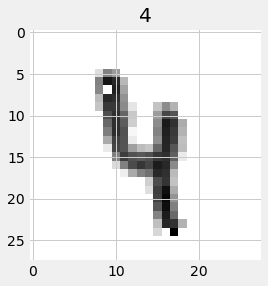

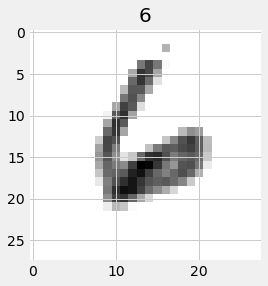

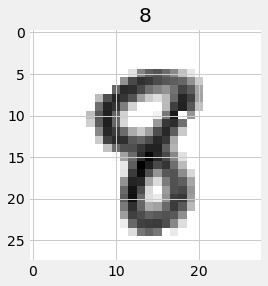

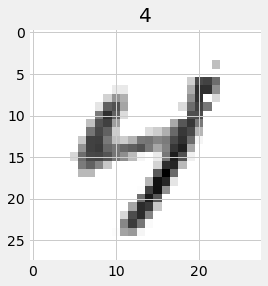

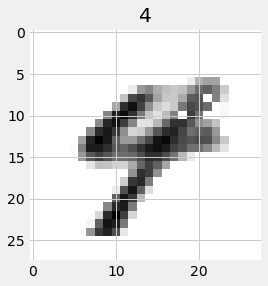

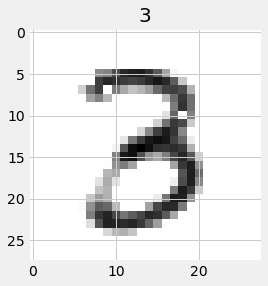

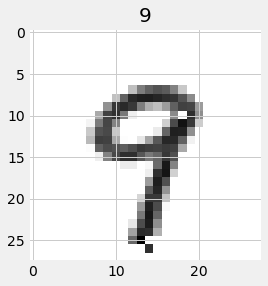

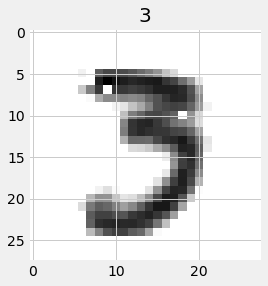

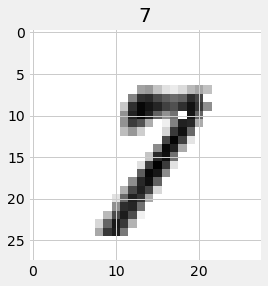

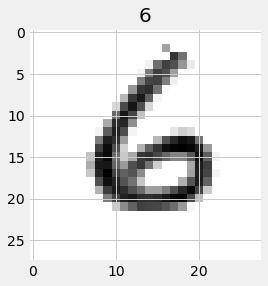

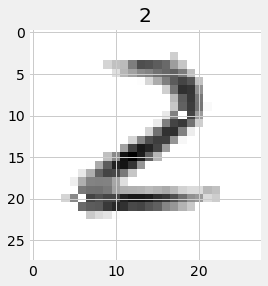

In [63]:
# load the best model and test how the encoder decoder setup works
checkpoint_filename = 'auto_encoder_mnist.pt'
model = Encoder_Decoder()
model.load_state_dict(torch.load(checkpoint_filename))
for i in range(20):
    test = next(iter(test_loader))
    test_img = test[0].view(28,28)
    label = test[1].item()
    out = model(test_img).view(28,28).detach().numpy()
    plt.imshow(out, cmap = 'binary')
    plt.title(f'{label}')
    plt.show()


10 feature vectors added


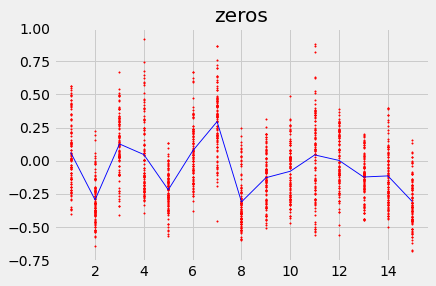

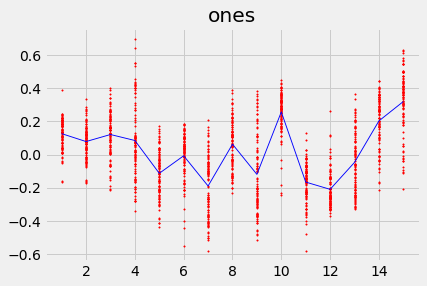

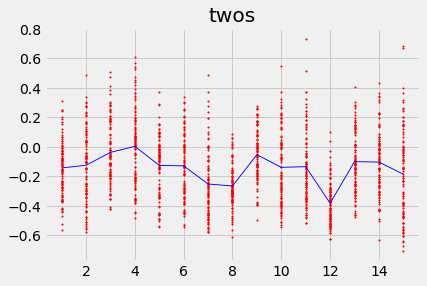

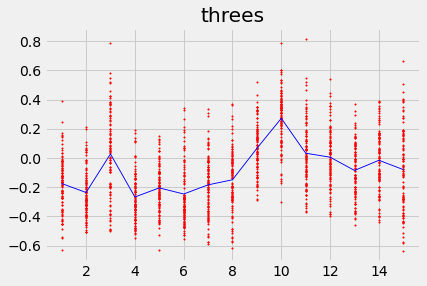

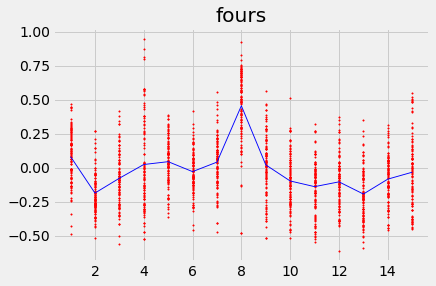

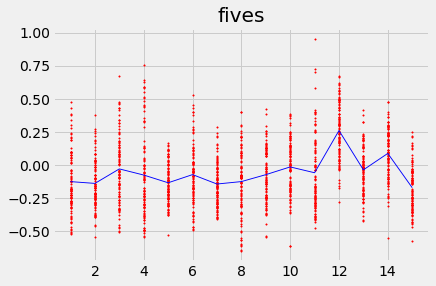

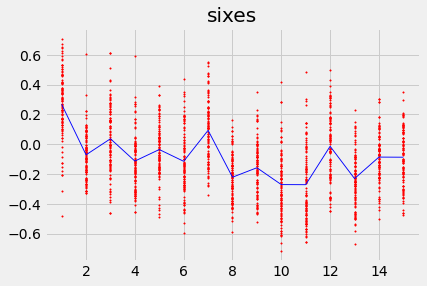

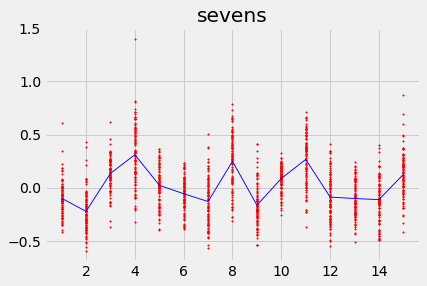

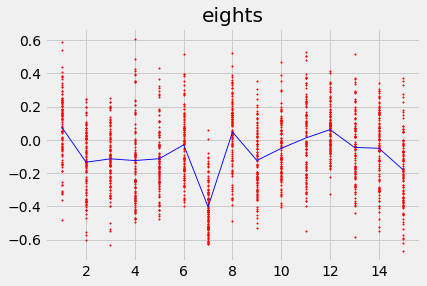

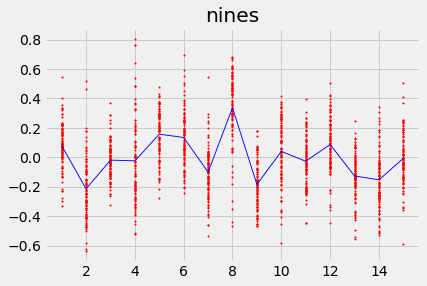

In [64]:
# Semi supervised learning
no_of_labeled_datapoints = 100 # per each class i.e. 5 percent of the test data is labeled
keys = ['zeros','ones','twos','threes','fours','fives','sixes','sevens','eights','nines']
dict_ = {
    'zeros': [[],0],
    'ones':[[],0],
    'twos': [[],0],
    'threes': [[],0],
    'fours': [[],0],
    'fives': [[],0],
    'sixes': [[],0],
    'sevens': [[],0],
    'eights': [[],0],
    'nines': [[],0]  
}
for i in tqdm(range(10)):
    test = iter(test_loader)
    while len(dict_[keys[i]][0]) != no_of_labeled_datapoints:
        test = next(iter(test_loader))
        test_img = test[0].view(28,28)
        label = test[1].item()
        if label == i:
            out = model.enc_pass(test_img).detach().numpy()
            dict_[keys[i]][0].append(out)
        else:
            pass
# Check the encoder output
feature_vectors = []
for i in tqdm(range(len(keys))):
    sum_vector = np.zeros(bottle_neck_dims).reshape(1,bottle_neck_dims)
    for lst in (dict_[keys[i]][0]):
        sum_vector += np.asarray(lst)
    sum_vector = sum_vector/len(dict_[keys[i]][0])
    dict_[keys[i]][1] = sum_vector
    feature_vectors.append(sum_vector)
print(len(feature_vectors), 'feature vectors added')
# Plot the feature vectors with their mean
for i in range(len(keys)):
    y = dict_[keys[i]][1][0]
    x = [j+1 for j in range(len(y))]
    plt.plot(x,y,color='blue',linewidth = 0.9)
    for lst in dict_[keys[i]][0]:
        plt.scatter(x, lst, 2, color = 'red')
    plt.title(keys[i])
    plt.show()

In [65]:
# Check accuracy of the semi-supervised learning algorithm(Classification)
def classify(output, feature_vectors):
    out = output.detach().numpy()
    error_scores = []
    for vector in feature_vectors:
        diff = np.asarray(vector) - out
        score = np.sum(diff*diff)
        error_scores.append(score)
    return np.argmin(error_scores)

test_data = iter(test_loader)
correct, total = 0, 0
for _ in tqdm(range(len(test_data))):
    test = next(test_data)
    test_img = test[0].view(28,28)
    label = test[1].item()
    out = model.enc_pass(test_img)[0]
    if label == classify(out, feature_vectors):
        correct+=1
    total+=1
print('Semi-supervised learning accuracy = ',correct/total*100, 'percent')


Semi-supervised learning accuracy =  80.23 percent
